In [51]:
from datetime import date, timedelta
import pandas as pd
import numpy as np
import warp_prism
import sqlalchemy as sa
import talib
import matplotlib.pyplot as plt
import seaborn

In [52]:
metadata = sa.MetaData()
engine = sa.create_engine('postgresql://developer:1@localhost:5432/go_finance')
tbl_prices = sa.Table(
    'prices', metadata,
    sa.Column('symbol', sa.String(16)),
    sa.Column('dt', sa.Date),
    sa.Column('open', sa.FLOAT),
    sa.Column('high', sa.FLOAT),
    sa.Column('low', sa.FLOAT),
    sa.Column('close', sa.FLOAT),
    sa.Column('volume', sa.BIGINT),
    sa.Column('adj', sa.FLOAT),
)

In [53]:
symbol = 'SPY'
query = sa.select(tbl_prices.c).where(
    tbl_prices.c.symbol.in_([symbol])
).order_by('symbol', 'dt')

is_adjusted = False
df = warp_prism.to_dataframe(query, bind=engine)
df.head()

,symbol,dt,open,high,low,close,volume,adj
0,SPY,1993-01-29,43.9687,43.9687,43.7500,43.9375,1003200,27.2351
1,SPY,1993-02-01,43.9687,44.2500,43.9687,44.2500,480500,27.4288
2,SPY,1993-02-02,44.2187,44.3750,44.1250,44.3437,201300,27.4869
3,SPY,1993-02-03,44.4062,44.8437,44.3750,44.8125,529400,27.7775
4,SPY,1993-02-04,44.9687,45.0937,44.4687,45.0000,531500,27.8937


In [54]:
# adjust
if not is_adjusted:
    ratio = df.adj / df.close
    df['open'] *= ratio
    df['high'] *= ratio
    df['low'] *= ratio
    df['close'] *= ratio
    df['volume'] = (df['volume'] / ratio).astype(int)
    is_adjusted = True
df.head()

,symbol,dt,open,high,low,close,volume,adj
0,SPY,1993-01-29,27.254440,27.254440,27.118876,27.2351,1618429,27.2351
1,SPY,1993-02-01,27.254433,27.428800,27.254433,27.4288,775175,27.4288
2,SPY,1993-02-02,27.409417,27.506302,27.351337,27.4869,324750,27.4869
3,SPY,1993-02-03,27.525651,27.796840,27.506311,27.7775,854063,27.7775
4,SPY,1993-02-04,27.874298,27.951781,27.564368,27.8937,857451,27.8937


# Market Trend

In [55]:
period = 200
roc = talib.ROC(df['close'].values, timeperiod=period)
df['roc200'] = roc
df.tail()

,symbol,dt,open,high,low,close,volume,adj,roc200
6409,SPY,2018-07-12,278.28,279.430,277.60,279.37,60124687,279.37,13.762136
6410,SPY,2018-07-13,279.17,279.930,278.66,279.59,48234964,279.59,13.783148
6411,SPY,2018-07-16,279.64,279.803,278.84,279.34,48201038,279.34,13.240422
6412,SPY,2018-07-17,278.47,280.910,278.41,280.47,52315500,280.47,13.562239
6413,SPY,2018-07-18,280.56,281.180,280.06,281.06,44593465,281.06,13.402528


In [56]:
df['roc200_smooth'] = (df['roc200'] + df['roc200'].shift(1)*2 + df['roc200'].shift(2)*2 + df['roc200'].shift(3)) / 6 
df.tail()

,symbol,dt,open,high,low,close,volume,adj,roc200,roc200_smooth
6409,SPY,2018-07-12,278.28,279.430,277.60,279.37,60124687,279.37,13.762136,13.025968
6410,SPY,2018-07-13,279.17,279.930,278.66,279.59,48234964,279.59,13.783148,13.281281
6411,SPY,2018-07-16,279.64,279.803,278.84,279.34,48201038,279.34,13.240422,13.473415
6412,SPY,2018-07-17,278.47,280.910,278.41,280.47,52315500,280.47,13.562239,13.561919
6413,SPY,2018-07-18,280.56,281.180,280.06,281.06,44593465,281.06,13.402528,13.465166


# Draw Chart

In [57]:
def month_tick_generator(x):
    """
    Generates ticks for every month
    """
    iterator = iter(x)
    prev_item = None
    for item in iterator:
        if prev_item is None or prev_item.month != item.month:
            yield item
        prev_item = item
        
def year_tick_generator(x):
    """
    Generates ticks for every Year
    """
    iterator = iter(x)
    prev_item = None
    for item in iterator:
        if prev_item is None or prev_item.year != item.year:
            yield item
        prev_item = item

def draw_chart(symbol, df, indy=[], filter_=None):
    """
    Draw price chart with indicators
    
    Params:
        symbol : ticker
        df : pd.DataFrame
        indy : list with indicators
        
    Return:
        None
    """
    fig = plt.figure(figsize=(15, 8), facecolor='white')

    # xticks
    if 'dt' in df.columns:
        dates = df['dt'].astype(object).values
        months = list(month_tick_generator(dates))
        years = list(year_tick_generator(dates))
        if len(df) > 2000:
            xticks = [i for i in range(0, len(dates)) if dates[i] in years]
            xticklabels = [dt.strftime('%Y') for dt in years]
        else:
            xticks = [i for i in range(0, len(dates)) if dates[i] in months]
            xticklabels = [dt.strftime('%b %y') for dt in months]
    else:
        xticklabels = xticks = list(df.index)

    # filter price chart
    df['close_filtered'] = df['close']    
    if filter_ is not None:
        df.loc[filter_, 'close_filtered'] = np.nan
        
    plotgrid = (1 + len(indy)) * 100 + 10
    plot_idx = 1
    ax1 = fig.add_subplot(plotgrid + plot_idx)  # x, y, subplots
    ax1.plot(df['close_filtered'].values, lw=1, label=symbol)  # price
    ax1.plot(df['close'].rolling(200).mean().values, lw=1, label='SMA(200)', color='r')  # SMA 200
    ax1.grid(True)
    ax1.legend()
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticklabels, size=8, rotation=60, ha='right')  # add x-ticks

    for indy in indy:
        plot_idx += 1
        ax_indy = fig.add_subplot(plotgrid + plot_idx, sharex=ax1)
        ax_indy.plot(df[indy].values, '-k', label=indy.upper(), linewidth=0.7)
        ax_indy.grid(True)
        ax_indy.axhline(0, color='black', linestyle='-', linewidth=1)
        if indy == 'tsi':
            ax_indy.axhline(0.5, color='black', linestyle='--', linewidth=0.5)
            ax_indy.axhline(-0.5, color='black', linestyle='--', linewidth=0.5)
        ax_indy.legend()
        ax_indy.set_xticklabels(xticklabels, size=8, rotation=60, ha='right')  # add x-ticks
        ax_indy.set_ylabel(indy.upper())    
    

# Compare ROCs

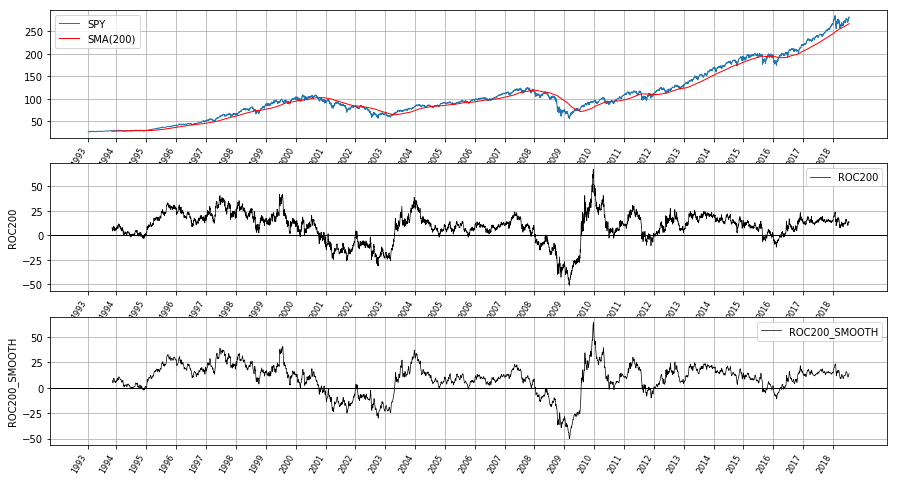

In [58]:
draw_chart(symbol, df, ['roc200', 'roc200_smooth'])
plt.show()

# TSI

In [59]:
def tsi(df, short, long):
    ratio = (df.close - df.close.shift(short)).abs() / talib.ATR(df.high.values, df.low.values, df.close.values, timeperiod=short)
    tsi = talib.SMA(talib.SMA(ratio.values, timeperiod=short), timeperiod=long) - 1  # substruct 1
    tsi[tsi < 0] = 0
    print("Min: {0} Max: {1}".format(tsi[~np.isnan(tsi)].min(), tsi[~np.isnan(tsi)].max()))    
    return tsi

df['tsi'] = tsi(df, 10, 50)  # 10, 50

for_sign = df.roc200.values.copy()
#for_sign[:] = -1
#for_sign[(df.close.rolling(1).mean() - df.close.rolling(200).mean() > 0) & (df.roc200 > 0)] = 1
df['tsi'] *= np.sign(for_sign)  # separate bull/bear trends
df.tail()

Min: 0.0 Max: 2.280102132398201


/home/alex/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


,symbol,dt,open,high,low,close,volume,adj,roc200,roc200_smooth,close_filtered,tsi
6409,SPY,2018-07-12,278.28,279.430,277.60,279.37,60124687,279.37,13.762136,13.025968,279.37,0.671048
6410,SPY,2018-07-13,279.17,279.930,278.66,279.59,48234964,279.59,13.783148,13.281281,279.59,0.695431
6411,SPY,2018-07-16,279.64,279.803,278.84,279.34,48201038,279.34,13.240422,13.473415,279.34,0.720806
6412,SPY,2018-07-17,278.47,280.910,278.41,280.47,52315500,280.47,13.562239,13.561919,280.47,0.753452
6413,SPY,2018-07-18,280.56,281.180,280.06,281.06,44593465,281.06,13.402528,13.465166,281.06,0.794839


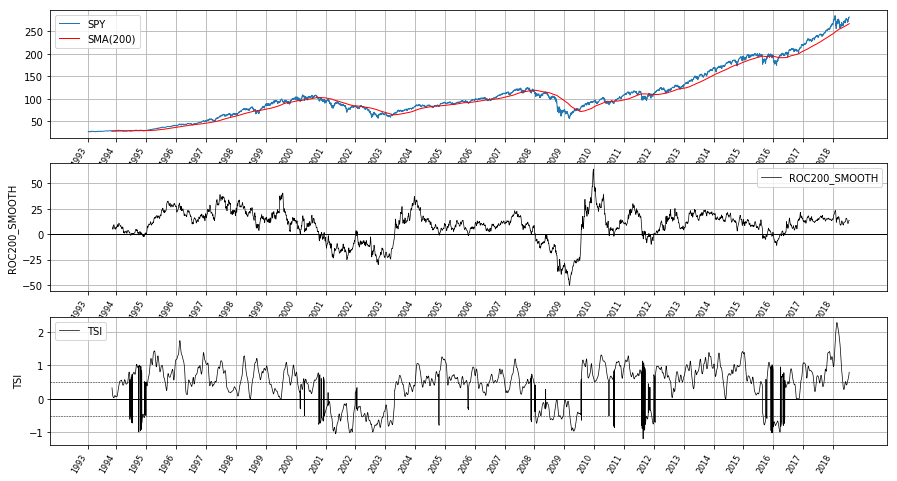

In [60]:
draw_chart(symbol, df, ['roc200_smooth', 'tsi'])  # , (df.tsi < 0.8) | (df.roc200_smooth < 0)
plt.show()

# Statistics

In [61]:
df['chg_price'] = df.close - df.close.shift(1)
df['chg'] = (df.close / df.close.shift(1) - 1) * 100
total = len(df.index)
# SMA200
sma200_chg = df[df.close.rolling(1).mean() - df.close.rolling(200).mean() > 0].chg_price.sum()
# SMA50x200
sma50x200_chg = df[df.close.rolling(50).mean() - df.close.rolling(200).mean() > 0].chg_price.sum()
print(sma200_chg, sma50x200_chg)
# ROC200
roc_chg = df[df.roc200 > 0].chg_price.sum()
# ROC200 & SMA200
#multi_chg = df[(df.close.rolling(1).mean() - df.close.rolling(200).mean() > 0) & (df.roc200 > 0)].chg_price.sum()
# smooth ROC200
smoothroc_chg = df[df.roc200_smooth > 0].chg_price.sum()
# total
total_chg = df.chg_price.sum()
results = []
for i in np.arange(0.0, 1.7, 0.1):
    positive = len(df[(df.tsi >= i) & (df.chg > 0)])
    total_trend = len(df[(df.tsi >= i)])
    positive_chg = df[(df.tsi >= i)].chg_price.sum()
    results.append((i, positive, total_trend, positive/total_trend * 100 if total_trend else 0, total_trend/total * 100, positive_chg, roc_chg, smoothroc_chg, sma200_chg, total_chg))
    
results = pd.DataFrame(results, 
                       columns=['TSI', 'Growth Days', 'Total Trend', 'Ratio, %', 'Tradable, %', 'TSI Change, $', 'ROC(200) Change, $', 's.ROC(200) Change, $', 'SMA(200) Change, $', 'Total Change, $'])
results

456.6086 254.7637


,TSI,Growth Days,Total Trend,"Ratio, %","Tradable, %","TSI Change, $","ROC(200) Change, $","s.ROC(200) Change, $","SMA(200) Change, $","Total Change, $"
0,0.0,2709,4931,54.938146,76.878703,379.2563,379.2563,242.885,456.6086,253.8249
1,0.1,2620,4785,54.754441,74.602432,351.5938,379.2563,242.885,456.6086,253.8249
2,0.2,2513,4578,54.892966,71.375117,351.4032,379.2563,242.885,456.6086,253.8249
3,0.3,2354,4300,54.744186,67.040848,321.0219,379.2563,242.885,456.6086,253.8249
4,0.4,2199,4000,54.975000,62.363580,305.7111,379.2563,242.885,456.6086,253.8249
5,0.5,1874,3429,54.651502,53.461179,254.4838,379.2563,242.885,456.6086,253.8249
6,0.6,1587,2862,55.450734,44.621141,244.4520,379.2563,242.885,456.6086,253.8249
7,0.7,1255,2260,55.530973,35.235423,214.0691,379.2563,242.885,456.6086,253.8249
8,0.8,959,1748,54.862700,27.252884,157.7575,379.2563,242.885,456.6086,253.8249
9,0.9,732,1328,55.120482,20.704708,111.8026,379.2563,242.885,456.6086,253.8249


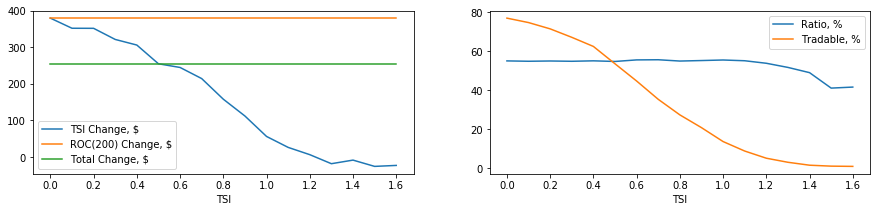

In [62]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3));
results[['TSI', 'TSI Change, $', 'ROC(200) Change, $', 'Total Change, $']].set_index('TSI').plot(ax=axes[0])
results[['TSI', 'Ratio, %', 'Tradable, %']].set_index('TSI').plot(ax=axes[1])
plt.show()